In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import geoplot as gplt
#import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.LogDataHandling import *
from Problem.PerformanceObserver import *

from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.utils import *
from Problem.Sigma_adapted_functions  import *
# 2 3 11
fraction_type = "11"
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK25_2"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
dataset = "fraction_{}".format(fraction_type)
sigma_routes = pd.read_pickle("sigma_data/sigma_solutions.pickle")[int(fraction_type)].to_list()[0]

sigma_starts = [s[0] for s in sigma_routes]
sigma_ends = [s[-1] for s in sigma_routes]

fraction_max_weight = {"2":500,"3":300,"11":1000}

sigma_data = pd.read_csv("sigma_data/data_frac_{}.csv".format(fraction_type))
pickups = sigma_data.where(sigma_data.Type ==1).dropna()
dropoffs = sigma_data.where(sigma_data.Type >1).dropna()
terminals = sigma_data.where(sigma_data.Type == 3).dropna()
sigma_demands_DF = separate_large_demands(sigma_data,fraction_max_weight[fraction_type],sigma_starts)
sigma_demands = sigma_demands_DF.Demand.astype(float).to_numpy()
sigma_station_data = sigma_demands_DF.rename(columns={"Demand":"Demand(kg)"})#pd.DataFrame(data=sigma_demands,columns=["Demand(kg)"])
meta_data["Customer Amount"] = len(sigma_data)
sigma_lat = sigma_data.Lat.to_numpy()
sigma_long = sigma_data.Long.to_numpy()
sigma_coordinates = np.array([sigma_lat,sigma_long]).T


sigma_distance_matrix,sigma_time_matrix = load_saved_here_data("sigma_data/","sigma_{}".format(fraction_type))#
sigma_distance_matrix = sigma_distance_matrix.to_numpy()
sigma_time_matrix = sigma_time_matrix.to_numpy()

dataset_names = ["fraction_2","fraction_3","fraction_11"]
sigma_routing_context = RoutingContext(distance_matrix=sigma_distance_matrix,time_matrix=sigma_time_matrix,station_coordinates=sigma_coordinates,station_data=sigma_station_data,meta_data=meta_data)
sigma_routes = pd.read_pickle("sigma_data/sigma_solutions.pickle")


In [3]:
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}

In [4]:
imgs_path = "../src/imgs"

In [5]:
from datetime import timedelta
def time_string_to_minutes(time_string):
    """
    https://stackoverflow.com/a/60638687/12463908
    """
    
    h =time_string
    delta = timedelta(hours=int(h.split(':')[0]), minutes=int(h.split(':')[1]), seconds=int(h.split(':')[2]))
    minutes = delta.total_seconds()/60
    return minutes

def get_sigma_results():
    logpath = "parameter_data/sigma_results/"
    
    frac_2 = pd.read_csv("{}/fraction_2/sigma_results.csv".format(logpath))
    frac_3 = pd.read_csv("{}/fraction_3/sigma_results.csv".format(logpath))
    frac_11 = pd.read_csv("{}/fraction_11/sigma_results.csv".format(logpath))
    
    return frac_2,frac_3,frac_11

def get_initial_results():
    
    logpath = "parameter_data/sigma_results/"
    
    frac_2 = pd.read_csv("{}/fraction_2/initial_solution.csv".format(logpath))
    frac_3 = pd.read_csv("{}/fraction_3/initial_solution.csv".format(logpath))
    frac_11 = pd.read_csv("{}/fraction_11/initial_solution.csv".format(logpath))
    
    return frac_2,frac_3,frac_11
        

In [6]:
def plot_vehicle_drivetimes(dataframe,dataset):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    dataframe_parameter_group = dataframe.where(dataframe.dataset == dataset).dropna(how="all")
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(len)
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)

    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna(how="all")

        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        mean_route_time_sum = int(np.round(sum(vehicle_route_times_mean),0))
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles:\ %s min$" % (vehicle_amount, mean_route_time_sum))
    max_vehicle_amount = vehicle_amounts[-1]
    plt.xticks(ticks=range(0,max_vehicle_amount),labels=range(1,max_vehicle_amount+1))
    plt.ylabel("Drive Time (minutes)",fontsize=42)
    plt.xlabel("Vehicle nr",fontsize=42)
    plt.legend(fontsize=32)
        

# Helper functions

In [7]:
def _mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), sp.stats.sem(a)
    h = se * sp.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def find_fithess_within_percentage_df(dataframe,percentage):
    time_points=[]
    for index,row in dataframe.iterrows():
        final_val = row.fuel_consumption_final
        worst_value_index = np.argsort(row.fuel_consumption)[-1] 

        percentage_range_value = final_val * (1 + percentage)
        if (worst_value := np.array(row.fuel_consumption)[worst_value_index])  < percentage_range_value:
                percentage_range_value = worst_value 

        if final_val == worst_value:
            time_points.append(np.array(row.computation_times)[0])
            continue

        within_range = np.argwhere(np.diff(np.sign(percentage_range_value - np.array(row.fuel_consumption)))).flatten()
        result = list(filter(lambda x: x >= worst_value_index,within_range))[0]
        time_points.append(np.array(row.computation_times)[result])
    return time_points


def add_final_compute_time_column(dataframe):
    if not "computation_times_final" in dataframe.columns:
        if type(dataframe.computation_times.iloc[0]) == str:
            dataframe.computation_times = dataframe.computation_times.apply(literal_eval)
        
        
        dataframe["computation_times_final"] = find_fithess_within_percentage_df(dataframe,0.05)#[dataframe.computation_times.loc[i][-1] for i in list(dataframe.index)]


def combine_datasets(algorithm_name, log_data_path, datasets=["UK25_2", "UK25_4", "UK25_8", "UK50_1", "UK50_2", "UK50_4", "UK75_1","UK75_3","UK75_6"]):
    simulations = []
    if type(datasets) == list:
        for dataset_name in datasets:
            try:
                simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
            except:
                print("Error, file not found: %s%s/%s.csv" % (log_data_path, dataset_name, algorithm_name))
            if dataset_name == "UK25_2":
                try:
                    simulation = remove_unwanted_mutation_parameter_groups(simulation)
                    if algorithm_name == "SA":
                        simulation["Parameter Group"] = simulation["Parameter Group"]/2
                    else:
                        simulation["Parameter Group"] = sorted(list(range(45)) * 30)
                except:
                    #print("No parameter groups to alter.")
                    pass
            simulation["dataset"] = dataset_name
            simulations.append(simulation)
    else:
            try:
                simulation = pd.read_csv("%s%s/%s.csv" % (log_data_path, datasets, algorithm_name))
            except:
                print("Error, file not found: %s%s/%s.csv" % (log_data_path, datasets, algorithm_name))
            if datasets == "UK25_2":
                try:
                    simulation = remove_unwanted_mutation_parameter_groups(simulation)
                    if algorithm_name == "SA":
                        simulation["Parameter Group"] = simulation["Parameter Group"]/2
                    else:
                        simulation["Parameter Group"] = sorted(list(range(45)) * 30)
                except:
                    #print("No parameter groups to alter.")
                    pass
            simulation["dataset"] = datasets
            simulations.append(simulation)
        
    
    for df in simulations:
        add_final_fitness_columns(df)
        try:
            expand_parameter_colums(df)
        except:
            #print("No parameter columns to expand")
            pass
        add_distance_to_origin(df)
        add_final_compute_time_column(df)
        
        df["num_evaluations"] = len(df.fitness.apply(literal_eval).apply(np.array)[0])*60
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final)
        df["fuel_consumption_final_mean"] = mean_f0
        df["fuel_consumption_final_min"] = min_f0
        df["fuel_consumption_final_max"] = max_f0
        
        max_fuel_consumption = max(df.fuel_consumption_final)
        min_fuel_consumption = min(df.fuel_consumption_final)
        df["fuel_consumption_final_minmax"] = (df.fuel_consumption_final - min_fuel_consumption)/(max_fuel_consumption - min_fuel_consumption)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.fuel_consumption_final_minmax)
        df["fuel_consumption_final_minmax_mean"] = mean_f0
        df["fuel_consumption_final_minmax_min"] = min_f0
        df["fuel_consumption_final_minmax_max"] = max_f0
        
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final)
        df["longest_route_time_final_mean"] = mean_f0
        df["longest_route_time_final_min"] = min_f0
        df["longest_route_time_final_max"] = max_f0
        
        max_longest_route_time_final = max(df.longest_route_time_final)
        min_longest_route_time_final = min(df.longest_route_time_final)
        df["longest_route_time_final_minmax"] = (df.longest_route_time_final - min_longest_route_time_final)/(max_longest_route_time_final - min_longest_route_time_final)
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.longest_route_time_final_minmax)
        df["longest_route_time_final_minmax_mean"] = mean_f0
        df["longest_route_time_final_minmax_min"] = min_f0
        df["longest_route_time_final_minmax_max"] = max_f0
        
        
        
        
        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.computation_times_final)
        df["computation_times_final_mean"] = mean_f0
        df["computation_times_final_min"] = min_f0
        df["computation_times_final_max"] = max_f0
        
        max_computation_times_final = max(df.computation_times_final)
        min_computation_times_final = min(df.computation_times_final)
        df["computation_times_final_minmax"] = (df.computation_times_final - min_computation_times_final)/(max_computation_times_final - min_computation_times_final)

        mean_f0, min_f0, max_f0 = _mean_confidence_interval(df.distance_to_origin)
        df["distance_to_origin_mean"] = mean_f0
        df["distance_to_origin_min"] = min_f0
        df["distance_to_origin_max"] = max_f0
        
        max_distance_to_origin = max(df.distance_to_origin)
        min_distance_to_origin = min(df.distance_to_origin)
        df["distance_to_origin_minmax"] = (df.distance_to_origin - min_distance_to_origin)/(max_distance_to_origin - min_distance_to_origin)
        
    return pd.concat(simulations)



def plot_2d_sigma(datapoints, labels, show_mean_eval=False, marker_kwargs={"SA":{"color":"#1f77b4", "marker":"o"}, "NSGA-II": {"color":"#ff7f0e", "marker":"P"}, "NSGA-III":{"color":"#2ca02c", "marker":"s"}, "IBEA":{"color":"#d62728", "marker":"D"}, "IBEA-Multiobjective":{"color":"#9467bd", "marker":">"}, "UNSGA-III":{"color":"#8c564b", "marker":"X"}, "GA":{"color":"#e377c2", "marker":"p"}}):
    
    
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig,ax = plt.subplots(1,1)
    for data, label in zip(datapoints, labels):

        mean_f0,min_f0,max_f0 =  data.fuel_consumption_final_mean, data.fuel_consumption_final_min, data.fuel_consumption_final_max
        mean_f1,min_f1,max_f1 =  data.longest_route_time_final_mean, data.longest_route_time_final_min, data.longest_route_time_final_max
        
        
        
        ax.plot([min_f0,max_f0],[mean_f1,mean_f1],zorder=1, c="k", linestyle="--")
       
        ax.plot([mean_f0,mean_f0],[min_f1,max_f1],zorder=1, c="k", linestyle="--")
        if show_mean_eval:
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {} \nMean Evaluations: {}".format(
                                                                                     round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                                     round(min_f1,2),round(mean_f1,2),round(max_f1,2), round(data.num_evaluations))
        else:
            plotlabel = r"$\bf{" + label + "}$" + ":\nFC - {} - $\mu$:{} - {}\nDT - {} - $\mu$:{} - {}".format(
                                                                         round(min_f0,2),round(mean_f0,2),round(max_f0,2),
                                                                         round(min_f1,2),round(mean_f1,2),round(max_f1,2))

        ax.scatter(x= mean_f0, y=mean_f1, label=plotlabel, s=250, **marker_kwargs[label], zorder=2)
        
    return fig, ax


In [8]:
def get_vehicles_for_fraction(fraction_typeterminals):
    sigma_routes = pd.read_pickle("sigma_data/sigma_solutions.pickle")[int(fraction_type)].to_list()[0]
    sigma_data = pd.read_csv("sigma_data/data_frac_{}.csv".format(fraction_type))
    terminals = sigma_data.where(sigma_data.Type == 3).dropna()
    sigma_starts = [s[0] for s in sigma_routes]

    startNodeIndeces = sigma_starts + terminals.index.to_list()
    vehicleData = {"emptyWeights":[3000],"maxLoads":[3650],"fuelEmpty":[12],"fuelFull":[15]}
    vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData)
    return vehicles

In [9]:
import time 
labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
start_time = time.monotonic()

print("SA")
SA_data = combine_datasets("SA", "parameter_data/sigma_results/",dataset_names)
print("GA")
GA_data = combine_datasets("GA", "parameter_data/sigma_results/",dataset_names)
print("NSGA2")
NSGA2_data = combine_datasets("NSGA2", "parameter_data/sigma_results/",dataset_names)
print("NSGA3")
NSGA3_data = combine_datasets("NSGA3", "parameter_data/sigma_results/",dataset_names)
print("UNSGA3")
UNSGA3_data = combine_datasets("UNSGA3", "parameter_data/sigma_results/",dataset_names)
print("IBEA")
IBEA_data = combine_datasets("IBEA", "parameter_data/sigma_results/",dataset_names)

# add_minmax_fuel_drivetime_columns([SA_data,GA_data,
#                                    NSGA2_data,NSGA3_data,
#                                    UNSGA3_data,IBEA_data])

SA_data_mean = SA_data.mean()
GA_data_mean = GA_data.mean()
NSGA2_data_mean = NSGA2_data.mean()
NSGA3_data_mean = NSGA3_data.mean()
UNSGA3_data_mean = UNSGA3_data.mean()
IBEA_data_data_mean = IBEA_data.mean()


print("Time: ", time.monotonic() - start_time)

SA
GA
NSGA2
NSGA3
UNSGA3
IBEA
Time:  0.6157175060034206


In [10]:
def plot_vehicle_drivetimes2(dataframe,dataset):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)

    dataframe_parameter_group = dataframe.where(dataframe.dataset == dataset).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    max_vehicle_amount = vehicle_amounts[-1]
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        mean_route_time_sum = int(np.round(sum(vehicle_route_times_mean),0))
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles:\ %s min$" % (vehicle_amount, mean_route_time_sum))
    plt.xticks(ticks=range(0,max_vehicle_amount),labels=range(1,max_vehicle_amount+1))
    plt.ylabel("Drive Time (minutes)",fontsize=42)
    plt.xlabel("Vehicle nr",fontsize=42)
    plt.legend(fontsize=32)
        

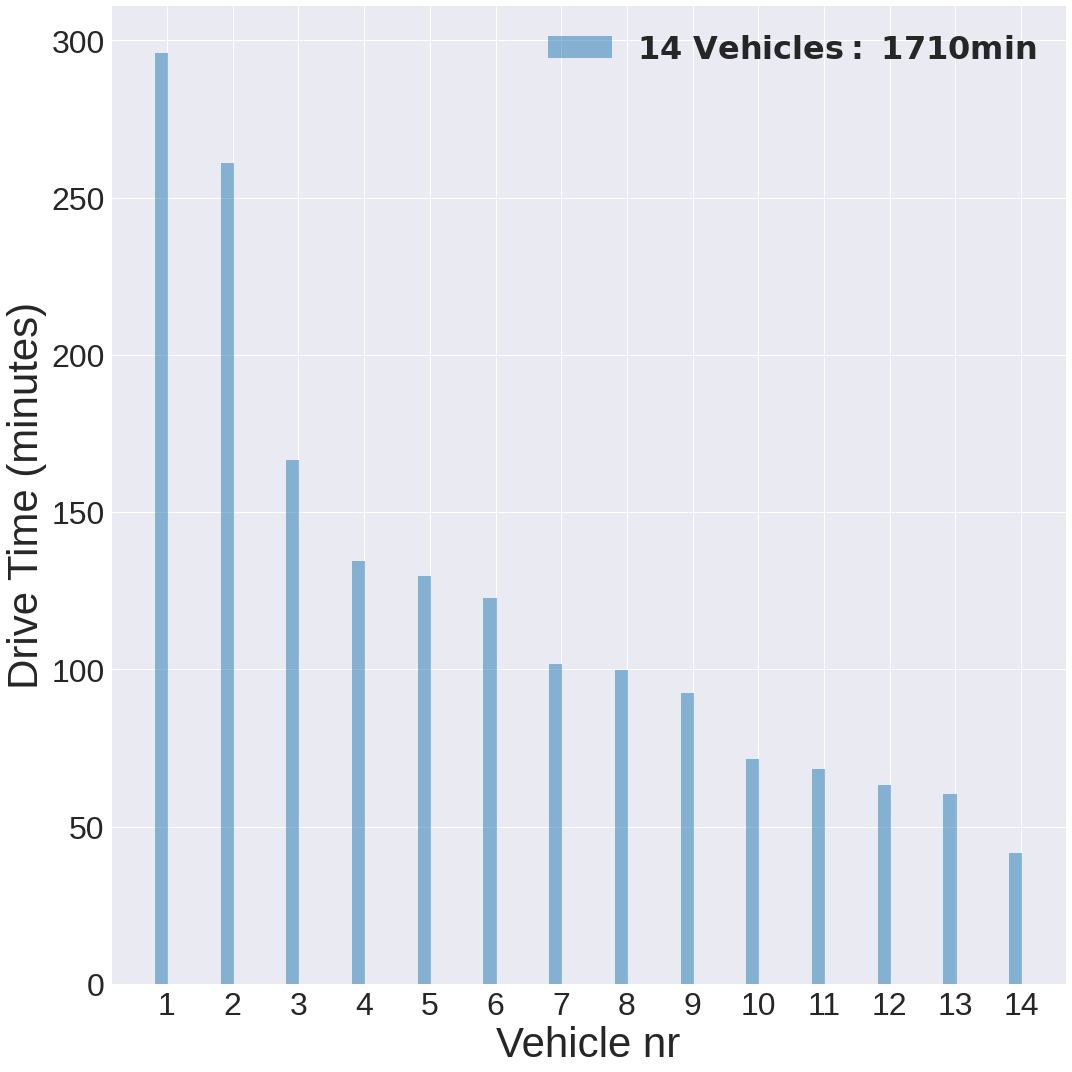

In [11]:
sigma_sol = get_sigma_results()[2]
sigma_sol["dataset"] = "fraction_11"
sigma_sol["vehicle_route_time"] = [[time_string_to_minutes(x)*60 for x in sigma_sol["Total Travel Time (h)"].to_list()]]*len(sigma_sol)
plot_vehicle_drivetimes2(sigma_sol,"fraction_11")
plt.tight_layout()
plt.savefig("drive_time_dist_sigmadata_3_sigma.pdf")

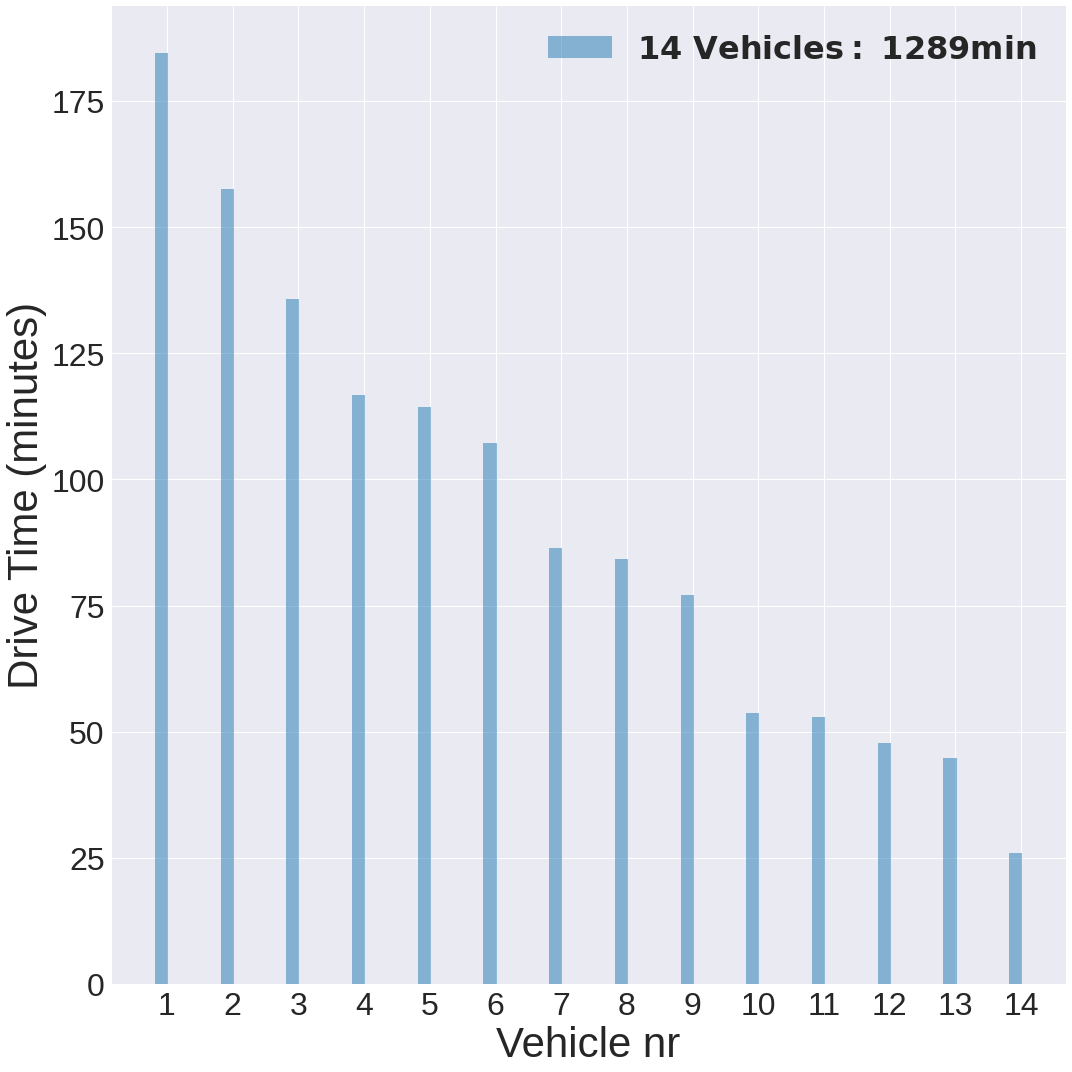

In [12]:

plot_vehicle_drivetimes(SA_data,"fraction_11")
plt.tight_layout()
plt.savefig("drive_time_dist_sigmadata_3_biobj_sa.pdf")
#total_drivetime = [sum(x)/(60**2) for x in IBEA_data.where(IBEA_data.dataset=="fraction_11").dropna(how="all").vehicle_route_time]

Gini mean  0.22977820795670736


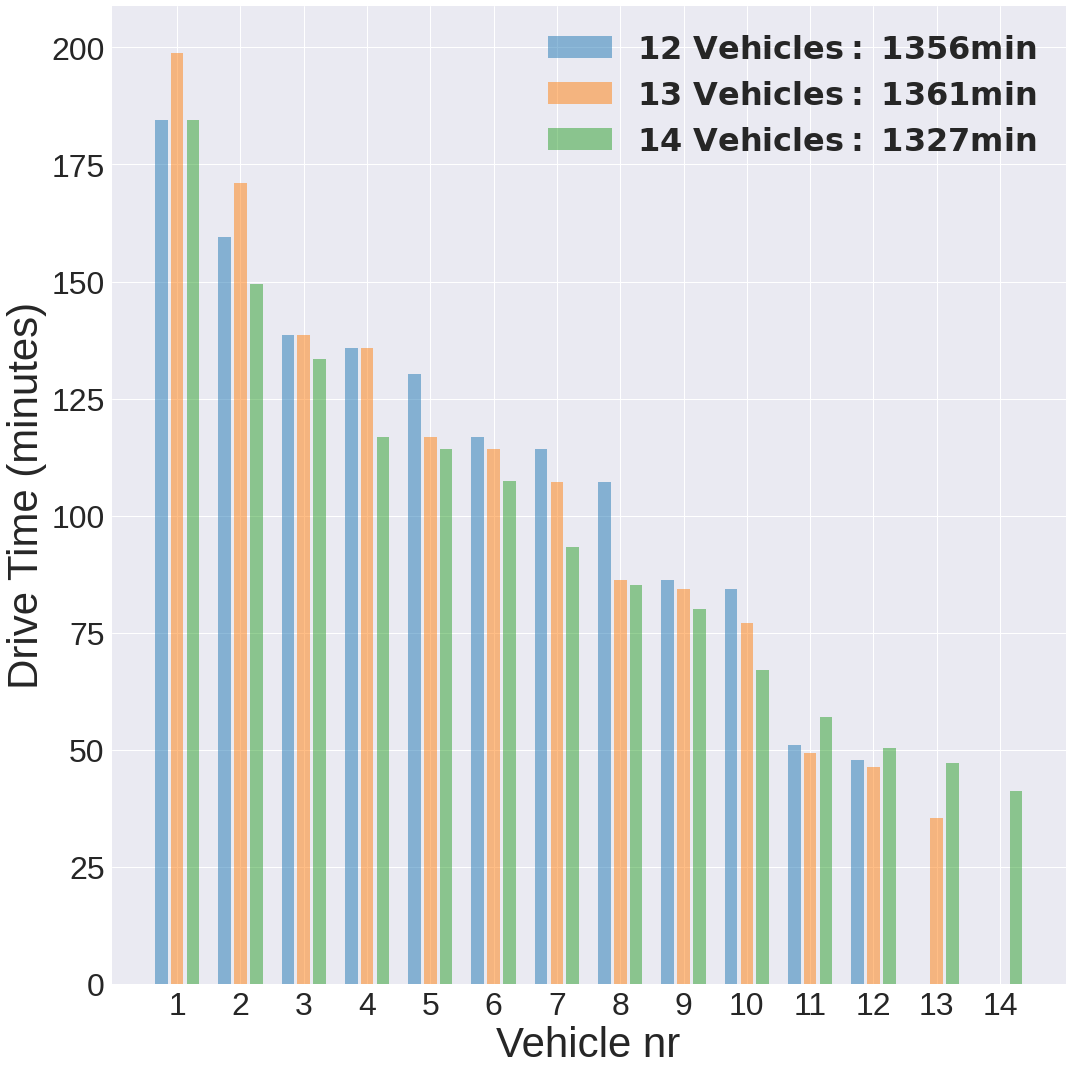

In [14]:
ibea_data_2 = pd.read_csv("parameter_data/sigma_results/fraction_11/IBEA_gini_third_objective_total_drivetime.csv")
add_final_fitness_columns(ibea_data_2)
print("Gini mean ",np.mean(get_gini_coefficients(ibea_data_2)))
ibea_data_2["dataset"] = "fraction_3"

plot_vehicle_drivetimes2(ibea_data_2,"fraction_3")
plt.tight_layout()
plt.savefig("drive_time_dist_sigmadata_3_multiobj.pdf")
#total_drivetime = [sum(x)/(60**2) for x in IBEA_data.where(IBEA_data.dataset=="fraction_11").dropna(how="all").vehicle_route_time]

# Show comparison with Sigma and Initial Solution

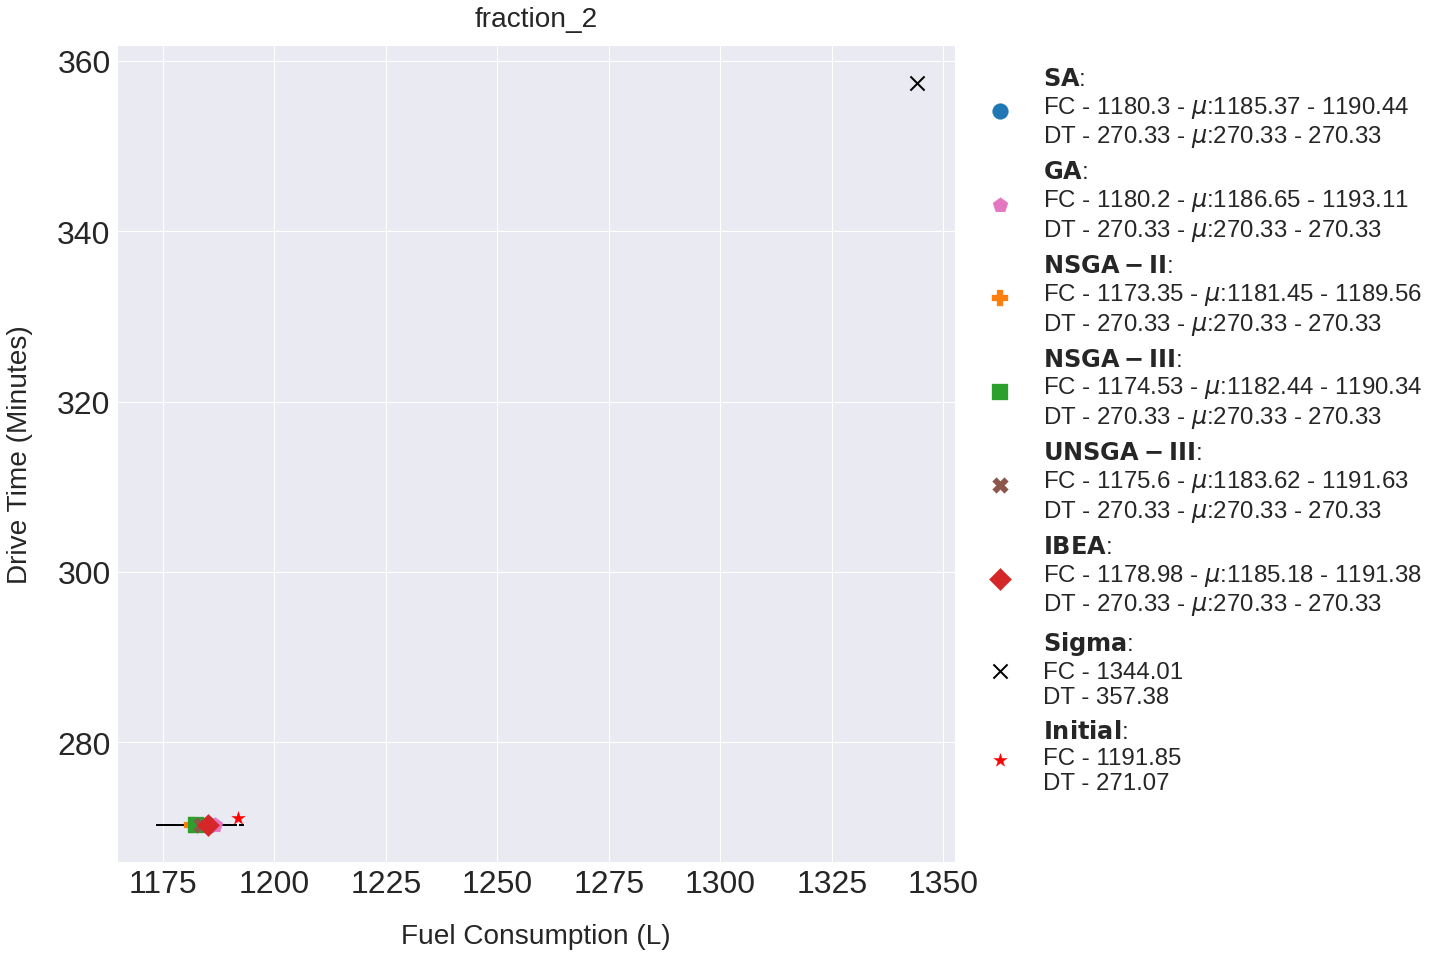

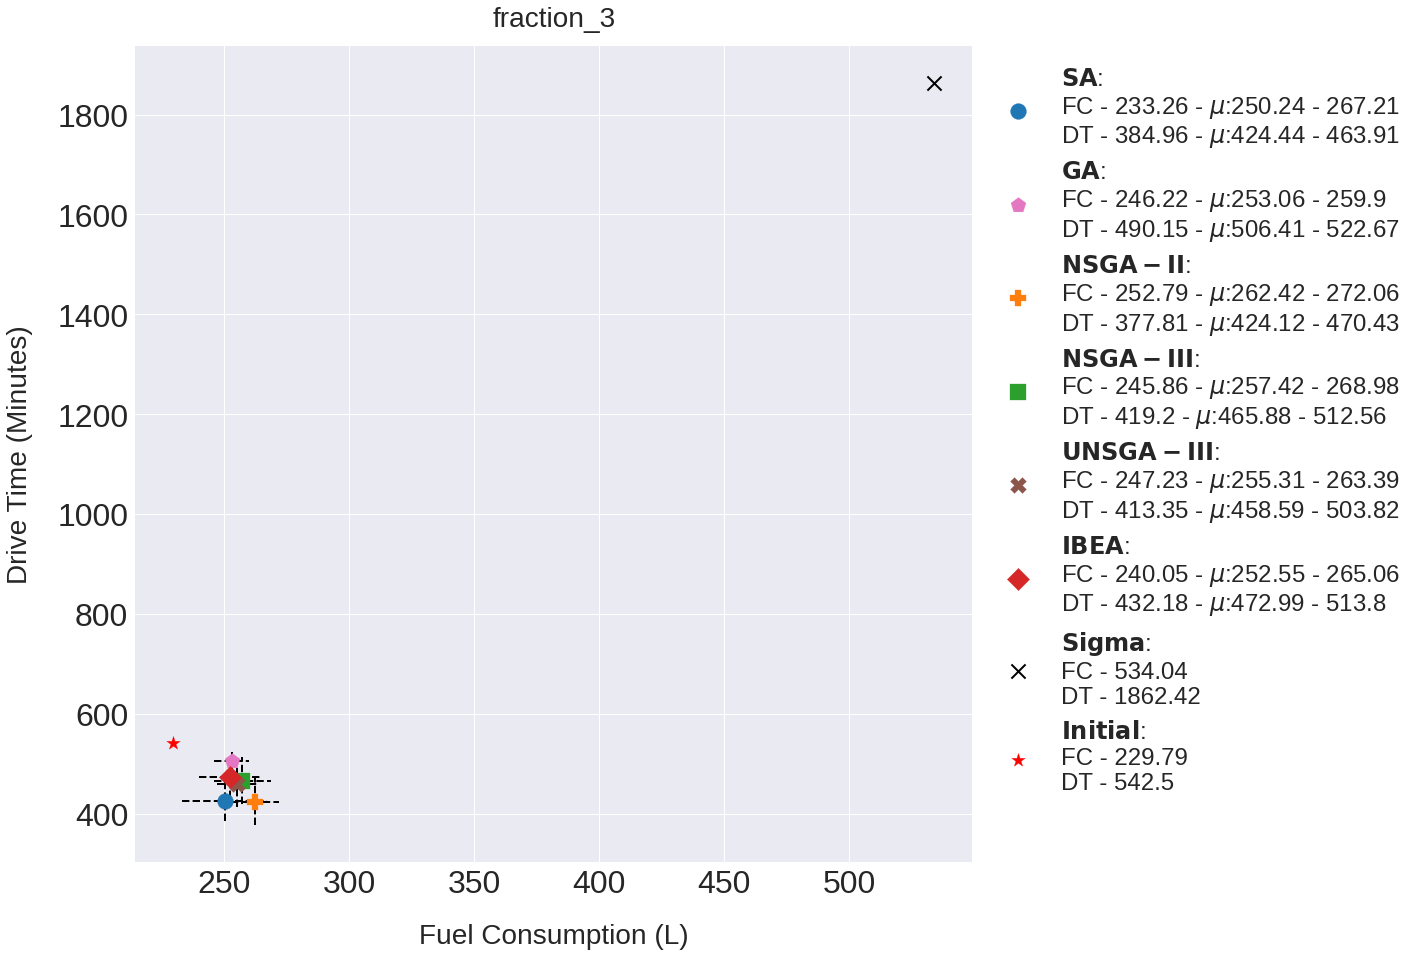

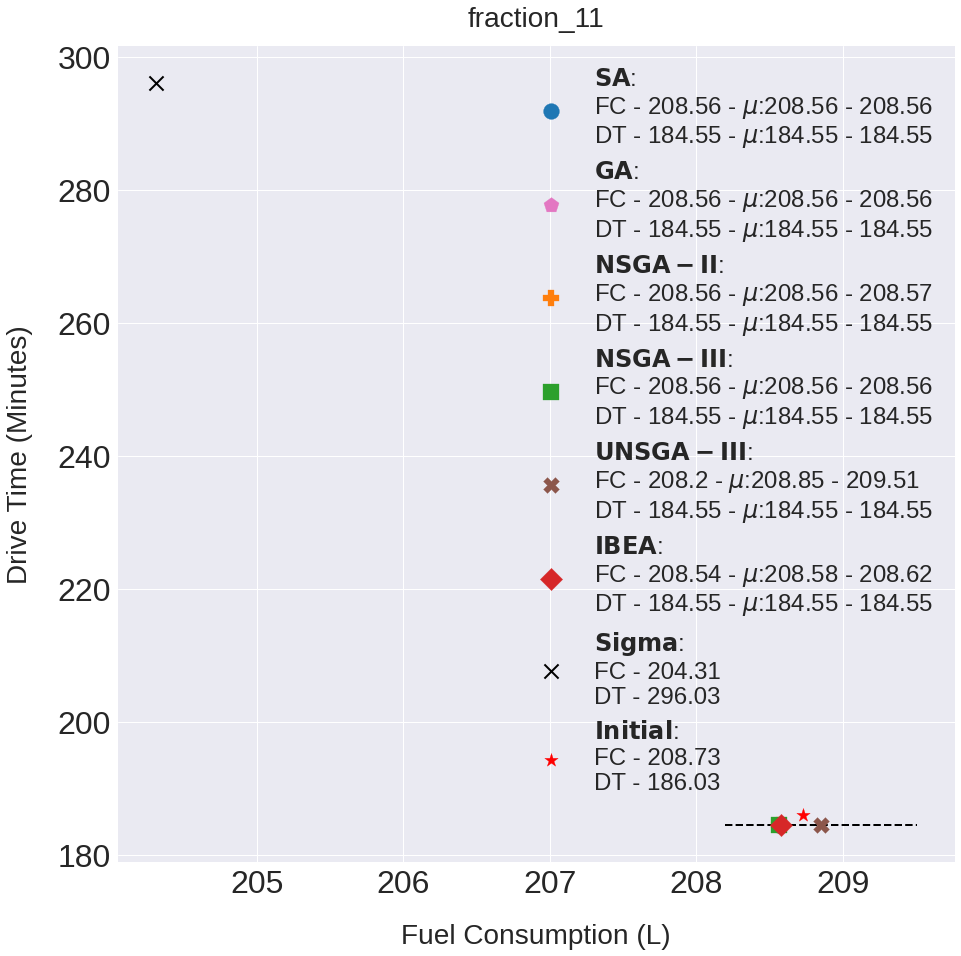

In [15]:
for dataset,sigma_sol,initial_sol in zip(dataset_names,get_sigma_results(),get_initial_results()):
    SA_data_dataset = SA_data.where(SA_data.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data.where(GA_data.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data.where(NSGA2_data.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data.where(NSGA3_data.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data.where(UNSGA3_data.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data.where(IBEA_data.dataset == dataset).dropna(how="all").mean()

    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    
    fig, ax = plot_2d_sigma(algorithms, labels)
    
    sigma_fuel = sigma_sol["Fuel Consumption (L)"].sum()
    sigma_drivetime = time_string_to_minutes(sigma_sol["Total Travel Time (h)"].max())
    sigma_label = r"$\bf{Sigma}$" + ":\nFC - {} \nDT - {} ".format(np.round(sigma_fuel,2),np.round(sigma_drivetime,2))
                                                                                     
    
    
    
    ax.scatter(x=sigma_fuel,y=sigma_drivetime,color="k",marker="x",s=200,label=sigma_label)
    
    
    initial_fuel = initial_sol["Fuel Consumption (L)"].sum()
    initial_drivetime = time_string_to_minutes(initial_sol["Total Travel Time (h)"].max())
    initial_label = r"$\bf{Initial}$" + ":\nFC - {} \nDT - {} ".format(np.round(initial_fuel,2),np.round(initial_drivetime,2))
    
    ax.scatter(x=initial_fuel,y=initial_drivetime,color="red",marker="*",s=200,label=initial_label)
    
    initial_sol
    
    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    
    plt.title(dataset)
    plt.show()

IBEA_data_third_objective = combine_datasets("IBEA_gini_third_objective_total_drivetime", "parameter_data/sigma_results/",["fraction_2","fraction_3","fraction_11"])
# Show without Sigma Comparison

In [31]:
IBEA_data_third_objective = combine_datasets("IBEA_gini_third_objective_total_drivetime", "parameter_data/sigma_results/",["fraction_2","fraction_3","fraction_11"])


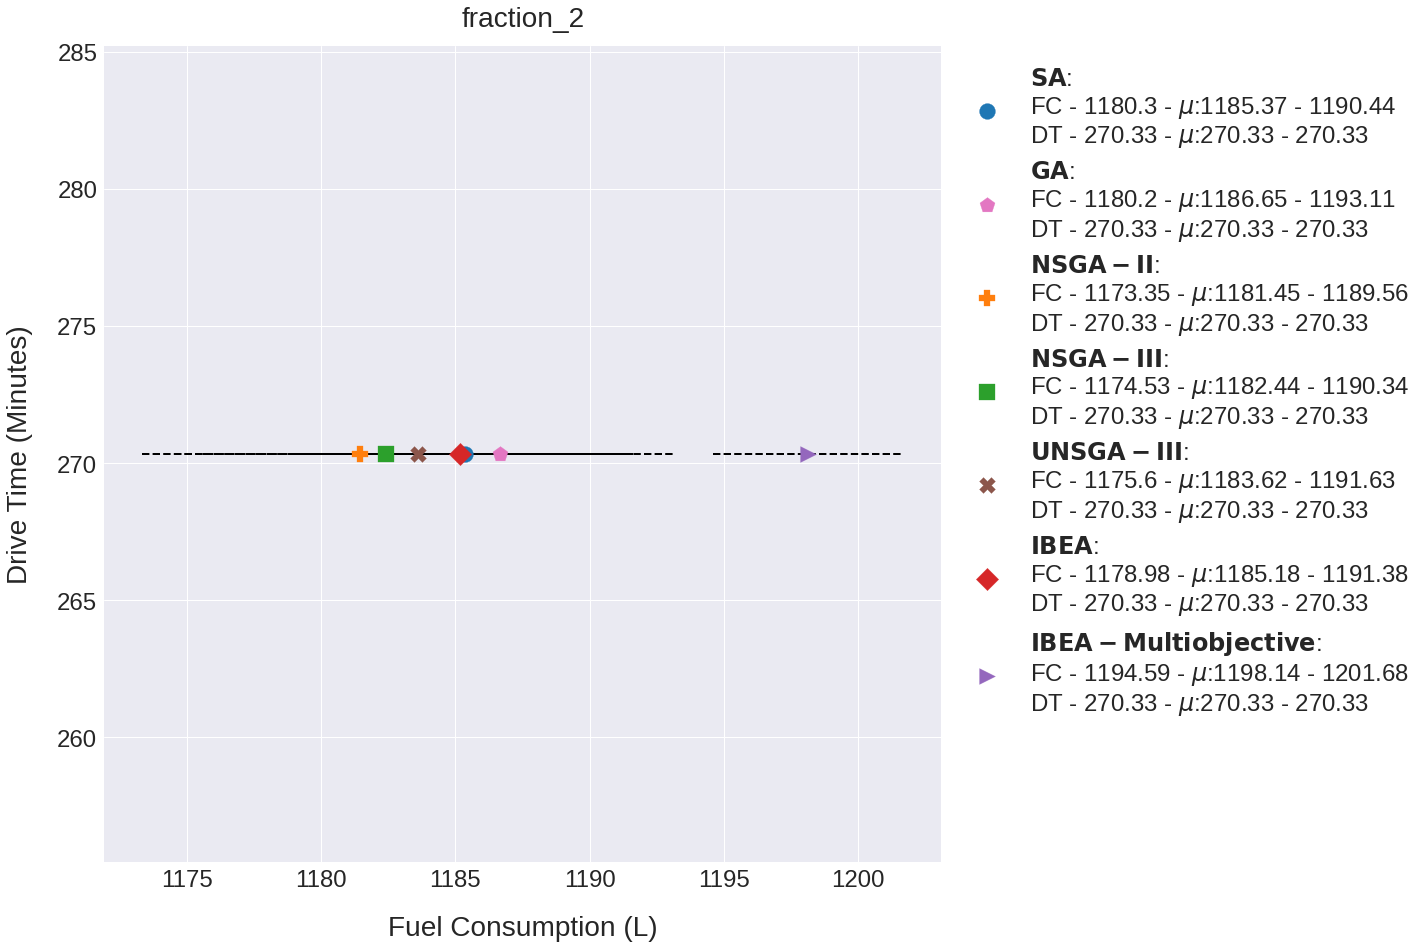

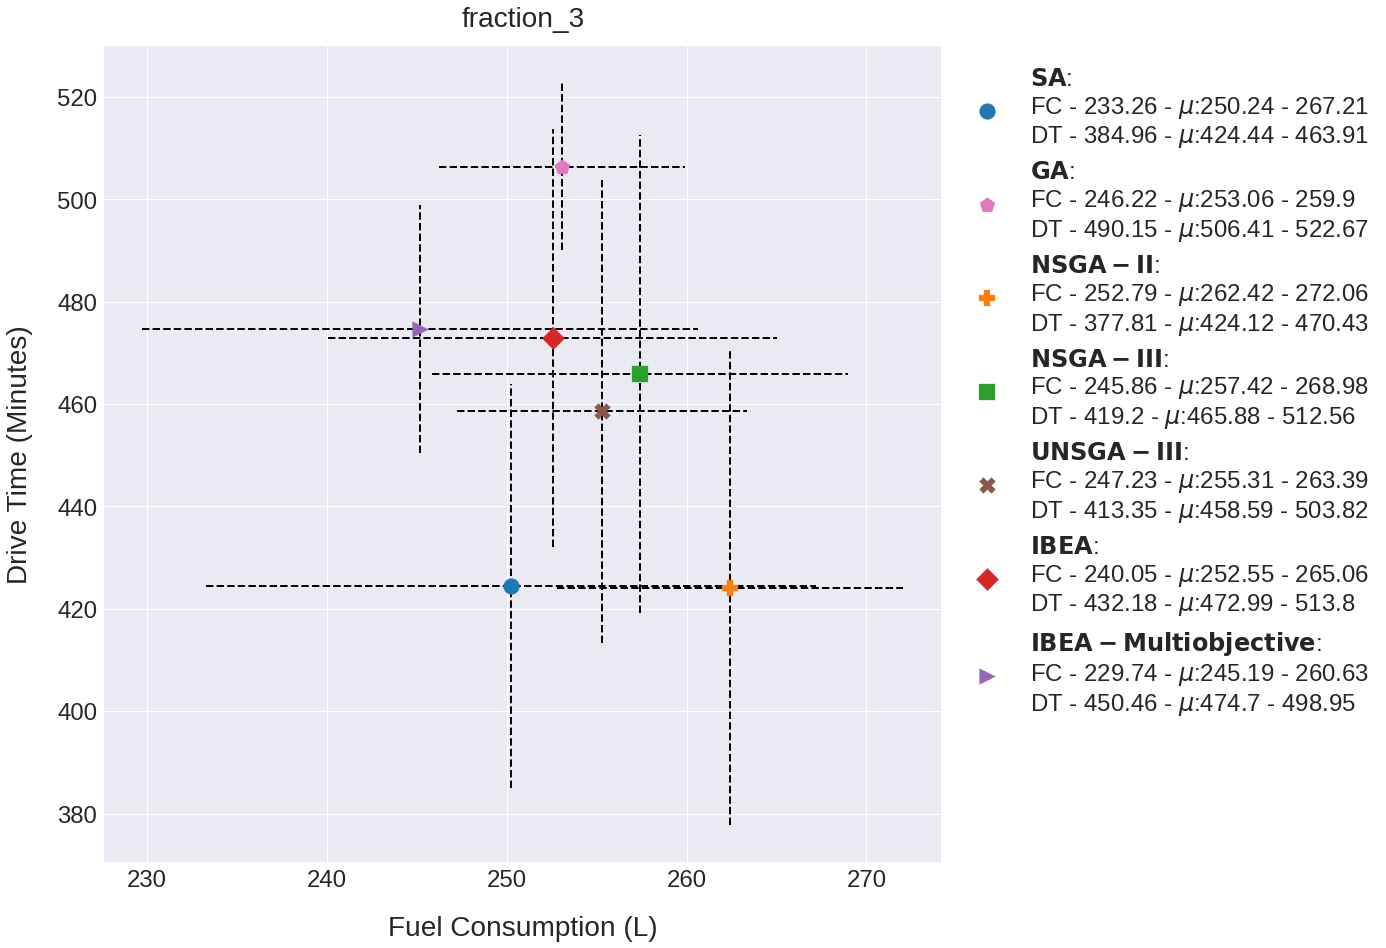

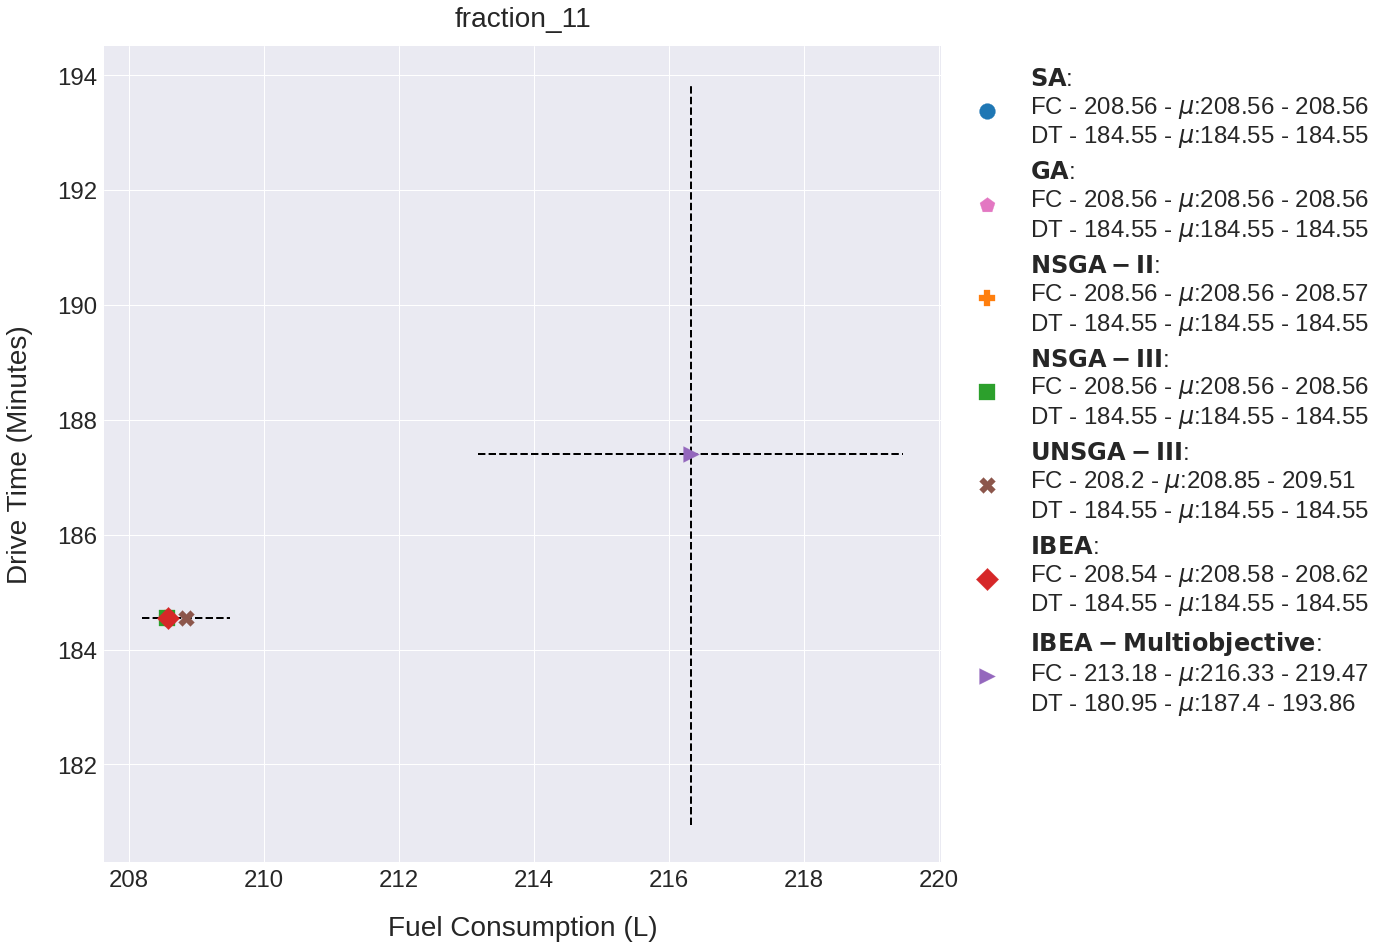

In [34]:
for dataset,sigma_sol,initial_sol in zip(dataset_names,get_sigma_results(),get_initial_results()):
    SA_data_dataset = SA_data.where(SA_data.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data.where(GA_data.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data.where(NSGA2_data.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data.where(NSGA3_data.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data.where(UNSGA3_data.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data.where(IBEA_data.dataset == dataset).dropna(how="all").mean()
    IBEA_data_third_objective_dataset = IBEA_data_third_objective.where(IBEA_data_third_objective.dataset == dataset).dropna(how="all").mean()
    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset,IBEA_data_third_objective_dataset]
    
    labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA","IBEA-Multiobjective"]
    fig, ax = plot_2d_sigma(algorithms, labels)
    

    
    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    
    plt.title(dataset)
    plt.show()

In [19]:
import time 
labels = ["SA", "GA", "NSGA-II", "NSGA-III", "UNSGA-III", "IBEA"]
start_time = time.monotonic()

print("SA")
SA_data_pickup_and_drop = combine_datasets("SA", "parameter_data/sigma_results/pick_and_drop/",dataset_names)
print("GA")
GA_data_pickup_and_drop = combine_datasets("GA", "parameter_data/sigma_results/pick_and_drop/",dataset_names)
print("NSGA2")
NSGA2_data_pickup_and_drop = combine_datasets("NSGA2", "parameter_data/sigma_results/pick_and_drop/",dataset_names)
print("NSGA3")
NSGA3_data_pickup_and_drop = combine_datasets("NSGA3", "parameter_data/sigma_results/pick_and_drop/",dataset_names)
print("UNSGA3")
UNSGA3_data_pickup_and_drop = combine_datasets("UNSGA3", "parameter_data/sigma_results/pick_and_drop/",dataset_names)
print("IBEA")
IBEA_data_pickup_and_drop = combine_datasets("IBEA", "parameter_data/sigma_results/pick_and_drop/",dataset_names)


SA_data_pickup_and_drop_mean = SA_data_pickup_and_drop.mean()
GA_data_pickup_and_drop_mean = GA_data_pickup_and_drop.mean()
NSGA2_data_pickup_and_drop_mean = NSGA2_data_pickup_and_drop.mean()
NSGA3_data_pickup_and_drop_mean = NSGA3_data_pickup_and_drop.mean()
UNSGA3_data_pickup_and_drop_mean = UNSGA3_data_pickup_and_drop.mean()
IBEA_data_pickup_and_drop_mean = IBEA_data_pickup_and_drop.mean()


print("Time: ", time.monotonic() - start_time)

SA
GA
NSGA2
NSGA3
UNSGA3
IBEA
Time:  0.5728672050026944


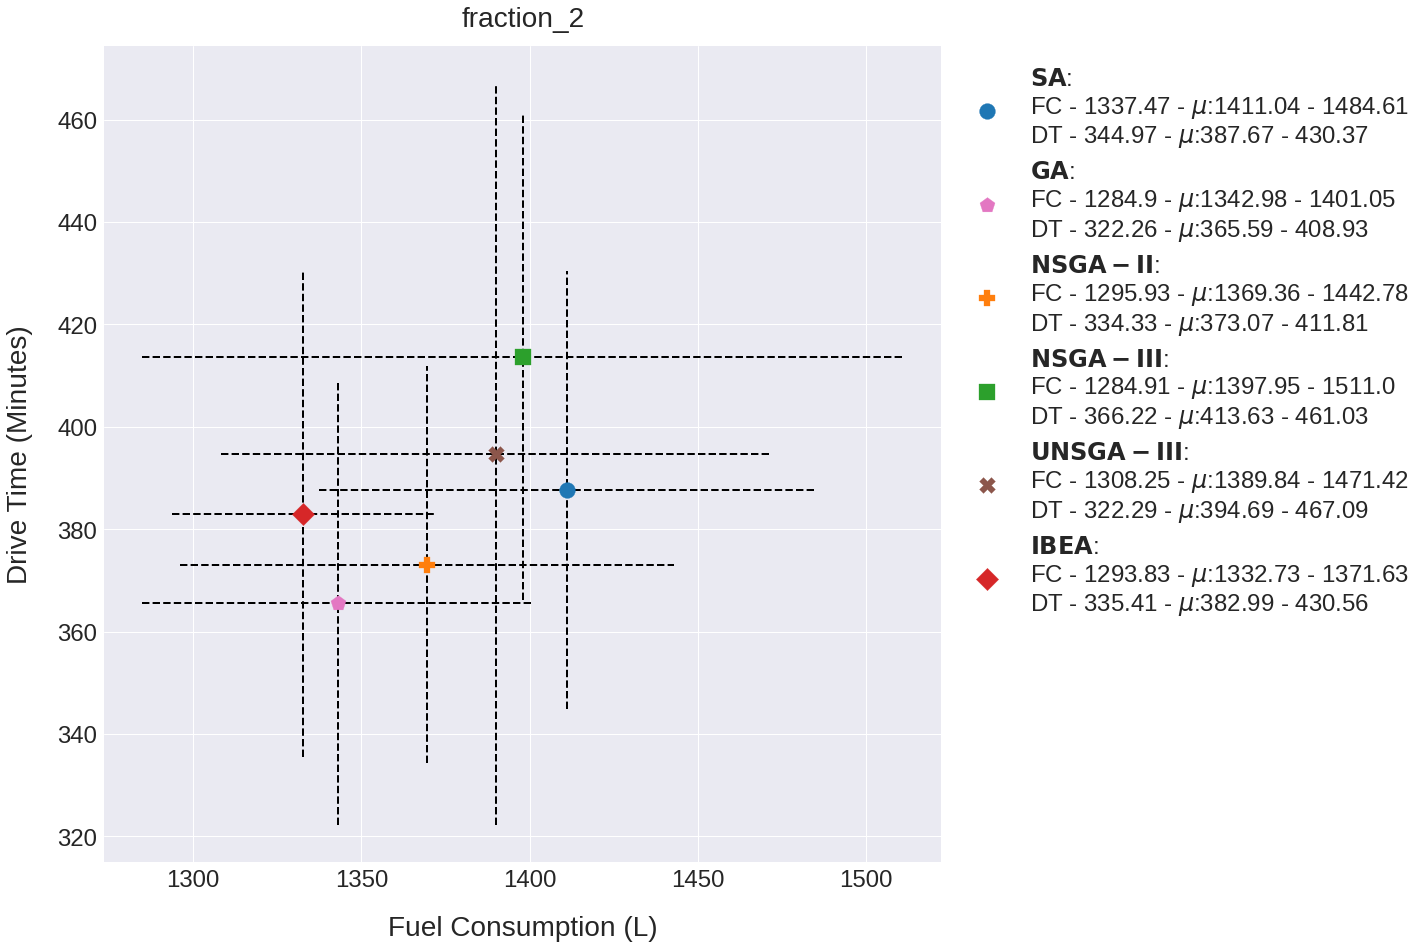

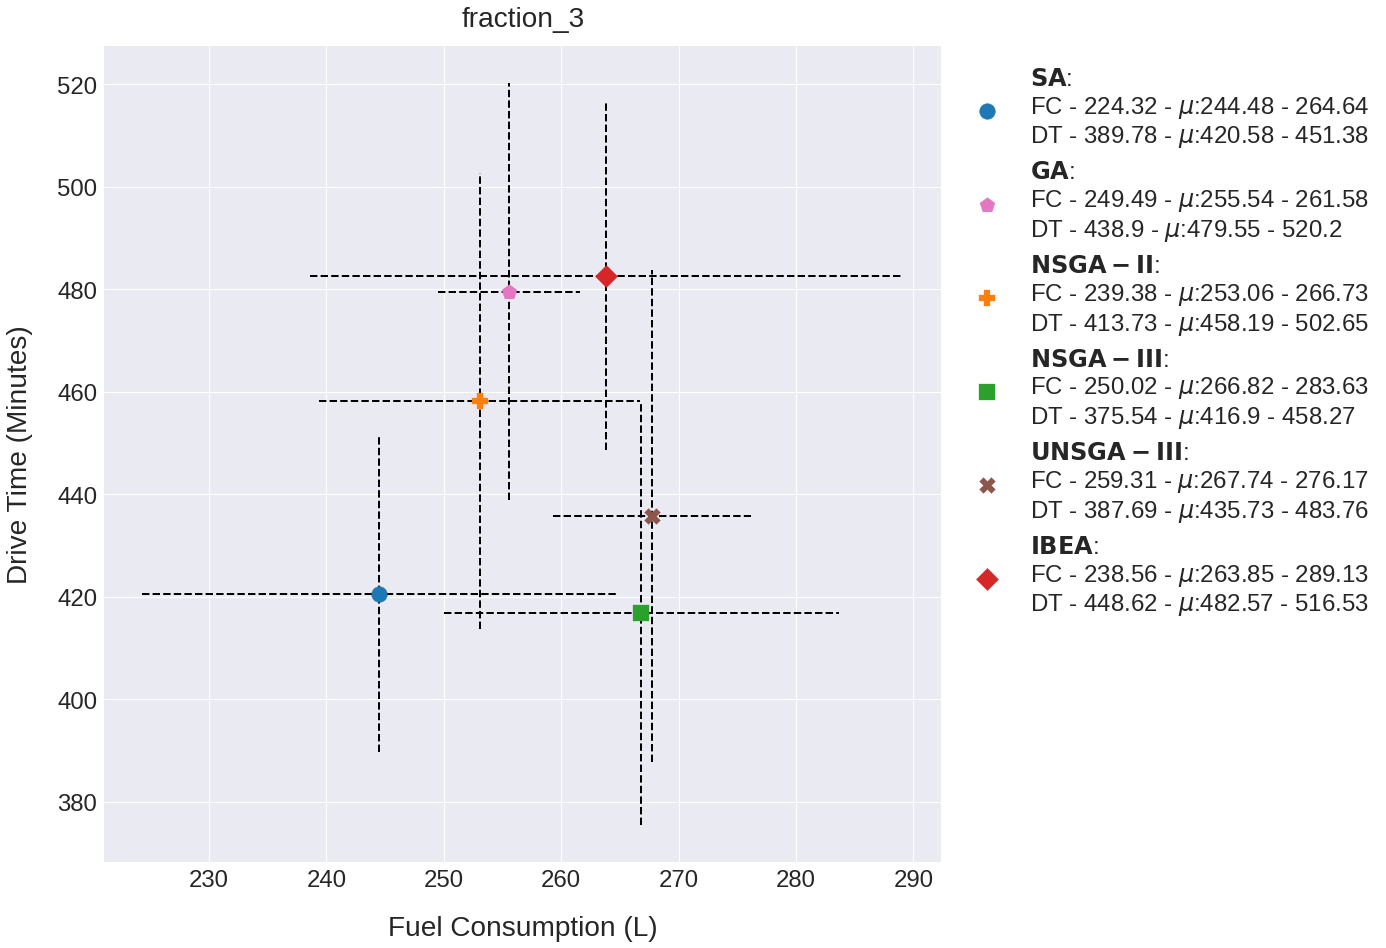

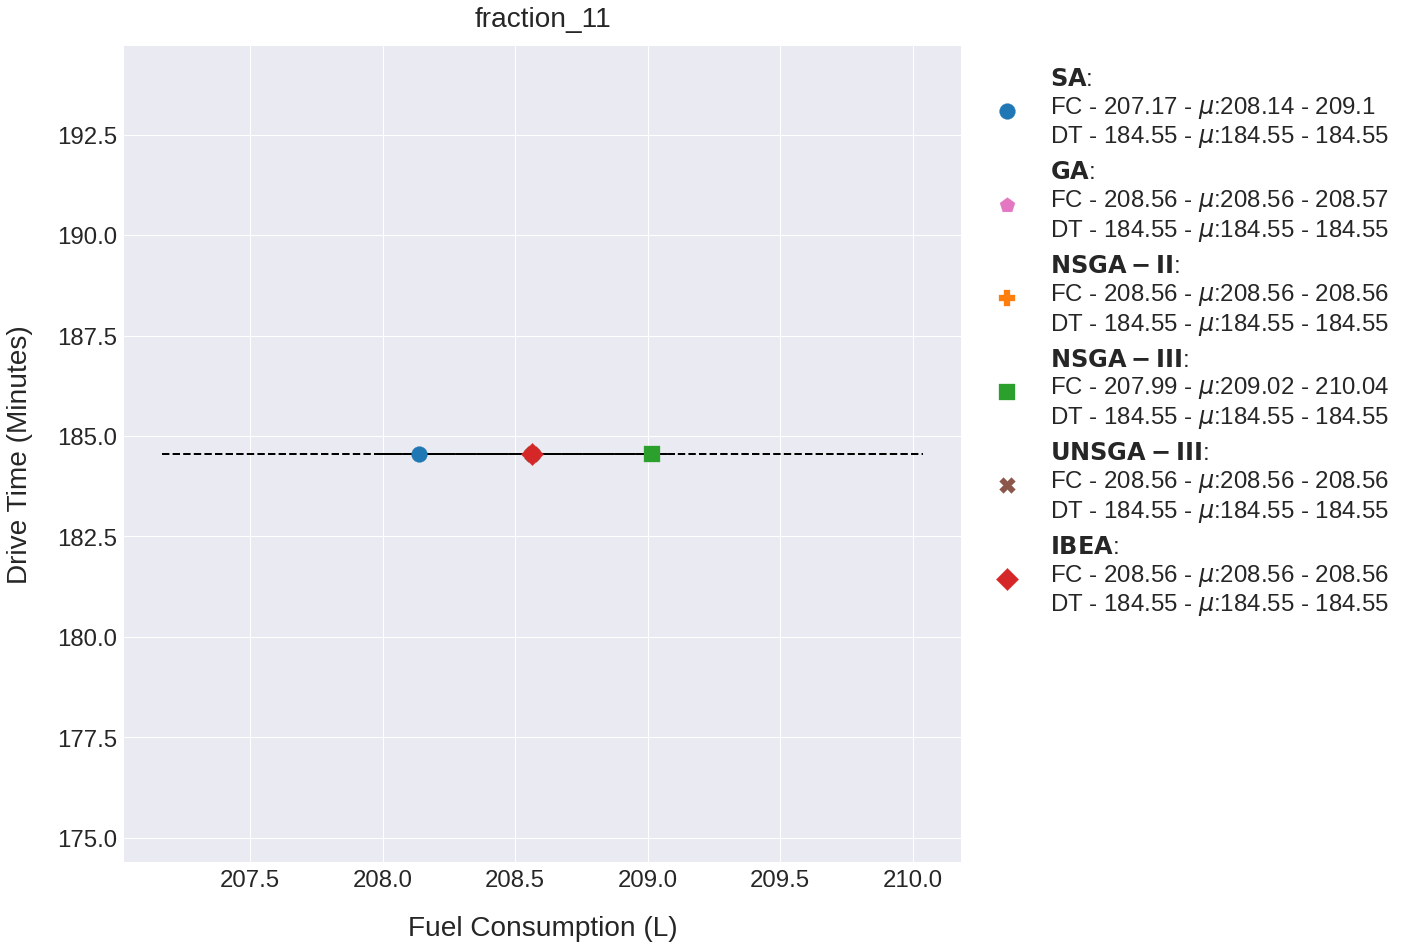

In [20]:
for dataset,sigma_sol,initial_sol in zip(dataset_names,get_sigma_results(),get_initial_results()):
    SA_data_dataset = SA_data_pickup_and_drop.where(SA_data.dataset == dataset).dropna(how="all").mean()
    GA_data_dataset = GA_data_pickup_and_drop.where(GA_data.dataset == dataset).dropna(how="all").mean()
    NSGA2_data_dataset = NSGA2_data_pickup_and_drop.where(NSGA2_data.dataset == dataset).dropna(how="all").mean()
    NSGA3_data_dataset = NSGA3_data_pickup_and_drop.where(NSGA3_data.dataset == dataset).dropna(how="all").mean()
    UNSGA3_data_dataset = UNSGA3_data_pickup_and_drop.where(UNSGA3_data.dataset == dataset).dropna(how="all").mean()
    IBEA_data_dataset = IBEA_data_pickup_and_drop.where(IBEA_data.dataset == dataset).dropna(how="all").mean()

    algorithms = [SA_data_dataset, GA_data_dataset, NSGA2_data_dataset, NSGA3_data_dataset, UNSGA3_data_dataset, IBEA_data_dataset]
    
    
    fig, ax = plot_2d_sigma(algorithms, labels)
    

    
    
    plt.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("Fuel Consumption (L)",labelpad=24)
    ax.set_ylabel("Drive Time (Minutes)",labelpad=24)
    
    
    
    plt.title(dataset)
    plt.show()

In [21]:
sa_path = SA_data.where(SA_data.dataset=="fraction_3").dropna(how="all").sort_values(by="longest_route_time_final").paths.iloc[0]
sa_path = literal_eval(sa_path)
sa_numerical_path = get_numerical_path(sa_path,get_vehicles_for_fraction("3"))

In [22]:
vehicle_routes = []

for v_route in sa_numerical_path:
    vehicle_routes.append(decode_routes(generate_routes(sigma_coordinates[np.array(v_route)%len(sigma_routing_context.distance_matrix)] ,api)))

 12%|█▎        | 1/8 [00:03<00:22,  3.26s/it]


KeyboardInterrupt: 

In [306]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=(58.5476627, 13.9489607), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
numerical_route = sa_numerical_path#get_numerical_path(plot_data_NSGAIII["paths"][0],vehicles)
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route[::-1]:
        nodeType = 0
        if route.index(stop) == len(route)-1:
            nodeType =2
        if route.index(stop) == 0:
            nodeType =1
        coordinates = (sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][0],sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00')).add_to(folium_map)
  
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map


In [309]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=(58.5476627, 13.9489607), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
numerical_route = sigma_routes[3][0]
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route:
        nodeType = 0
        if route.index(stop) == len(route)-1:
            nodeType =1
        if route.index(stop) == 0:
            nodeType =2
        coordinates = (sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][0],sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00')).add_to(folium_map)
  
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map


In [13]:
def compare_solutions(dataFrame1,dataFrame2):
    

    result = pd.DataFrame()
    dataFrame1_sum = pd.DataFrame(dataFrame1[["Total distance (km)","Fuel Consumption (L)"]].sum()).T
    df1_driveTime = pd.to_timedelta(dataFrame1["Total Travel Time (h)"]).sum()
    df1_driveTime_days = df1_driveTime.days
    df1_driveTime_seconds = df1_driveTime.seconds
    df1_driveTime_hours = int(df1_driveTime_seconds/(60**2))
    df1_driveTime_minutes = int(df1_driveTime_seconds/60) - df1_driveTime_hours *60 
    dataFrame1_sum["Total Travel Time (h)"] = (df1_driveTime_days*24 + df1_driveTime_hours) + df1_driveTime_minutes/60 
  
    
    dataFrame2_sum = pd.DataFrame(dataFrame2[["Total distance (km)","Fuel Consumption (L)"]].sum()).T
    df2_driveTime = pd.to_timedelta(dataFrame2["Total Travel Time (h)"]).sum()
    df2_driveTime_days = df2_driveTime.days
    df2_driveTime_seconds = df2_driveTime.seconds
    df2_driveTime_hours = int(df2_driveTime_seconds/(60**2))
    df2_driveTime_minutes = int(df2_driveTime_seconds/60) - df2_driveTime_hours *60 
    dataFrame2_sum["Total Travel Time (h)"] = (df2_driveTime_days*24 + df2_driveTime_hours) + df2_driveTime_minutes/60 
    
    result = pd.concat([dataFrame1_sum,dataFrame2_sum])
    result.index = ["Our Solution","Sigma Solution"]
    
    difference = pd.DataFrame(abs(result.loc["Our Solution"] - result.loc["Sigma Solution"])).T
    difference.index=["Difference"]
    
    difference_percentage = (difference/(result.loc["Sigma Solution"]) * 100)#.round(decimals=2)
    difference_percentage.index = ["Difference (%)"]
    
    result = pd.concat([result,difference,difference_percentage])
    
    return result

In [14]:
def compare_solution_to_sigma(our_results_ibea,our_results_sa,our_results_ibea_multi,sigma_solution):
        
        
        result = pd.DataFrame()
        
        result["Total Travel Time (h)"] = [our_results_ibea["Total Travel Time (h)"].mean(),our_results_sa["Total Travel Time (h)"].mean(),
                                           our_results_ibea_multi["Total Travel Time (h)"].mean(),np.round(sum([time_string_to_minutes(x)/60 for x in sigma_solution["Total Travel Time (h)"]]),2)] 
        
        
        
        
        result["Fuel Consumption (L)"] = [np.round(our_results_ibea.fuel_consumption_final.mean(),2),np.round(our_results_sa.fuel_consumption_final.mean(),2),
                                          np.round(our_results_ibea_multi.fuel_consumption_final.mean(),2),np.round(sum([x for x in sigma_solution["Fuel Consumption (L)"]]),2)]   
        
        result["Total distance (km)"] = [np.round(our_results_ibea.route_distance.apply(literal_eval).apply(sum).mean()/1000,2),np.round(our_results_sa.route_distance.apply(literal_eval).apply(sum).mean()/1000,2),
                                         np.round(our_results_ibea_multi.route_distance.apply(literal_eval).apply(sum).mean()/1000,2),np.round(sigma_solution["Total distance (km)"].sum(),2)]        
        
        result["Vehicle Amount"] = [np.round(our_results_ibea.route_distance.apply(literal_eval).apply(len).mean(),2),np.round(our_results_sa.route_distance.apply(literal_eval).apply(len).mean(),2),
                                         np.round(our_results_ibea_multi.route_distance.apply(literal_eval).apply(len).mean(),2),np.round(len(sigma_solution["Total distance (km)"]),2)]  
        
        result["Gini Index"] = [np.round(our_results_ibea["Gini Index"].mean(),3),np.round(our_results_sa["Gini Index"].mean(),3),
                                       np.round(our_results_ibea_multi["Gini Index"].mean(),3),  np.round(sigma_solution["Gini Index"].mean(),3)]     
        
        
        result.index = ["IBEA bi-objective","SA bi-objective","IBEA multi-objective","Sigma Solution"]
        
        
        return result

In [15]:
fraction_dataset = "fraction_2"

ibea_data_2 = pd.read_csv("parameter_data/sigma_results/{}/IBEA_gini_third_objective_total_drivetime.csv".format(fraction_dataset))
add_final_fitness_columns(ibea_data_2)
print("Gini mean ",np.mean(get_gini_coefficients(ibea_data_2)))
ibea_data_2["dataset"] = fraction_dataset



ibea_data_2["Total Travel Time (h)"] = [np.round(sum(x)/(60**2),2) for x in  ibea_data_2.vehicle_route_time]
ibea_data_2["Gini Index"] = get_gini_coefficients(ibea_data_2) 
ibea_data_2["Gini Index"].mean()

Gini mean  0.3814736263257643


0.3814736263257643

In [16]:
SA_bi_objective_fraction_data = NSGA3_data.where(NSGA3_data.dataset == fraction_dataset).dropna(how="all")

SA_bi_objective_fraction_data["Total Travel Time (h)"] = [np.round(sum(x)/(60**2),2) for x in  SA_bi_objective_fraction_data.vehicle_route_time]
SA_bi_objective_fraction_data["Gini Index"] = get_gini_coefficients(SA_bi_objective_fraction_data) 
SA_bi_objective_fraction_data["Gini Index"].mean()

0.401250600633644

In [17]:
IBEA_bi_objective_fraction_data = IBEA_data.where(IBEA_data.dataset == fraction_dataset).dropna(how="all")

IBEA_bi_objective_fraction_data["Total Travel Time (h)"] = [np.round(sum(x)/(60**2),2) for x in  IBEA_bi_objective_fraction_data.vehicle_route_time]
IBEA_bi_objective_fraction_data["Gini Index"] = get_gini_coefficients(IBEA_bi_objective_fraction_data) 
IBEA_bi_objective_fraction_data["Gini Index"].mean()

0.4001982783093032

In [18]:
fraction_index = {"fraction_2":0,"fraction_3":1,"fraction_11":2}
sigma_sol = get_sigma_results()[fraction_index[fraction_dataset]]
sigma_sol["vehicle_route_time"] = [[time_string_to_minutes(x) for x in sigma_sol["Total Travel Time (h)"].to_list()]]*len(sigma_sol)
sigma_sol["Gini Index"] = get_gini_coefficients(sigma_sol) 

In [19]:
compare_solution_to_sigma(IBEA_bi_objective_fraction_data,SA_bi_objective_fraction_data,ibea_data_2,sigma_sol).T

,IBEA bi-objective,SA bi-objective,IBEA multi-objective,Sigma Solution
Total Travel Time (h),110.537,110.232,112.848,154.990
Fuel Consumption (L),1185.180,1182.440,1198.140,1344.010
Total distance (km),7005.560,6989.210,7089.070,8557.690
Vehicle Amount,78.400,78.300,78.400,83.000
Gini Index,0.400,0.401,0.381,0.287


In [20]:
compare_solution_to_sigma(IBEA_bi_objective_fraction_data,SA_bi_objective_fraction_data,ibea_data_2,sigma_sol).T

,IBEA bi-objective,SA bi-objective,IBEA multi-objective,Sigma Solution
Total Travel Time (h),110.537,110.232,112.848,154.990
Fuel Consumption (L),1185.180,1182.440,1198.140,1344.010
Total distance (km),7005.560,6989.210,7089.070,8557.690
Vehicle Amount,78.400,78.300,78.400,83.000
Gini Index,0.400,0.401,0.381,0.287


In [21]:
sum([time_string_to_minutes(x) for x in sigma_sol["Total Travel Time (h)"]])/60

154.99000000000004

In [22]:
our_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles)
sigma_results = get_solution_results2(front_NSGAIII[0],routing_context=sigma_routing_context,vehicles=vehicles,paths_to_use=finished_sigma_routes)

comparison = compare_solutions(our_results,sigma_results)
comparison

NameError: name 'front_NSGAIII' is not defined

In [23]:
fractions = ["fraction_2","fraction_3","fraction_11"]

fraction_index = {"fraction_2":0,"fraction_3":1,"fraction_11":2}

our_fuel =[]
sigma_fuel = []
our_fuel_2 = []


our_time = []
sigma_time = []
our_time_2 = []
for fraction_dataset in fractions:



    ibea_data_2 = pd.read_csv("parameter_data/sigma_results/{}/IBEA_gini_third_objective_total_drivetime.csv".format(fraction_dataset))
    add_final_fitness_columns(ibea_data_2)

    ibea_data_2["dataset"] = fraction_dataset



    ibea_data_2["Total Travel Time (h)"] = [np.round(sum(x)/(60**2),2) for x in  ibea_data_2.vehicle_route_time]
    
    our_fuel.append(ibea_data_2.fuel_consumption_final.mean())
    our_time.append(ibea_data_2["Total Travel Time (h)"].mean())
    
    sigma_sol = get_sigma_results()[fraction_index[fraction_dataset]]
    sigma_sol["vehicle_route_time"] = [[time_string_to_minutes(x) for x in sigma_sol["Total Travel Time (h)"].to_list()]]*len(sigma_sol)
    sigma_sol["Gini Index"] = get_gini_coefficients(sigma_sol) 
    
    sigma_fuel.append(sigma_sol["Fuel Consumption (L)"].sum())
    sigma_time.append(sum(sigma_sol["vehicle_route_time"][0])/60)
    
    ibea_bi_obj = IBEA_data.where(IBEA_data.dataset == fraction_dataset).dropna(how="all")
    
    
    ibea_bi_obj["Total Travel Time (h)"] = [np.round(sum(x)/(60**2),2) for x in  ibea_bi_obj.vehicle_route_time]
    
    our_fuel_2.append(ibea_bi_obj.fuel_consumption_final.mean())
    our_time_2.append(ibea_bi_obj["Total Travel Time (h)"].mean())
    
    
our_fuel
    
    

[1198.1383754521228, 245.18644108958247, 216.3264325417311]

In [24]:
our_time

[112.848, 24.633999999999997, 22.375999999999998]

In [25]:
our_time_2

[110.53699999999999, 24.759999999999998, 21.494]

In [26]:
sigma_fuel
plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")

In [27]:
bi_obj_vehicles = [0.1,.29,.19,.1,.17,.15,.24,.22,.19]#[5.7,5.4,4.9,10,8.3,9,10.8,14,12.7]
multi_obj_vehicles = [.05,.29,.07,.16,.06,.16,.21,.26,.17]#[3,5,4,8.8,6.2,8,9.6,12.6,11.6]

In [28]:



bi_obj_vehicles = np.array(bi_obj_vehicles).reshape(3,3).mean(axis=1)
multi_obj_vehicles = np.array(multi_obj_vehicles).reshape(3,3).mean(axis=1)

In [29]:
np.array(multi_obj_vehicles).reshape(3,3).mean(axis=1)

ValueError: cannot reshape array of size 3 into shape (3,3)

In [30]:
x1 = np.arange(len(multi_obj_vehicles))
x2 = x1+0.4


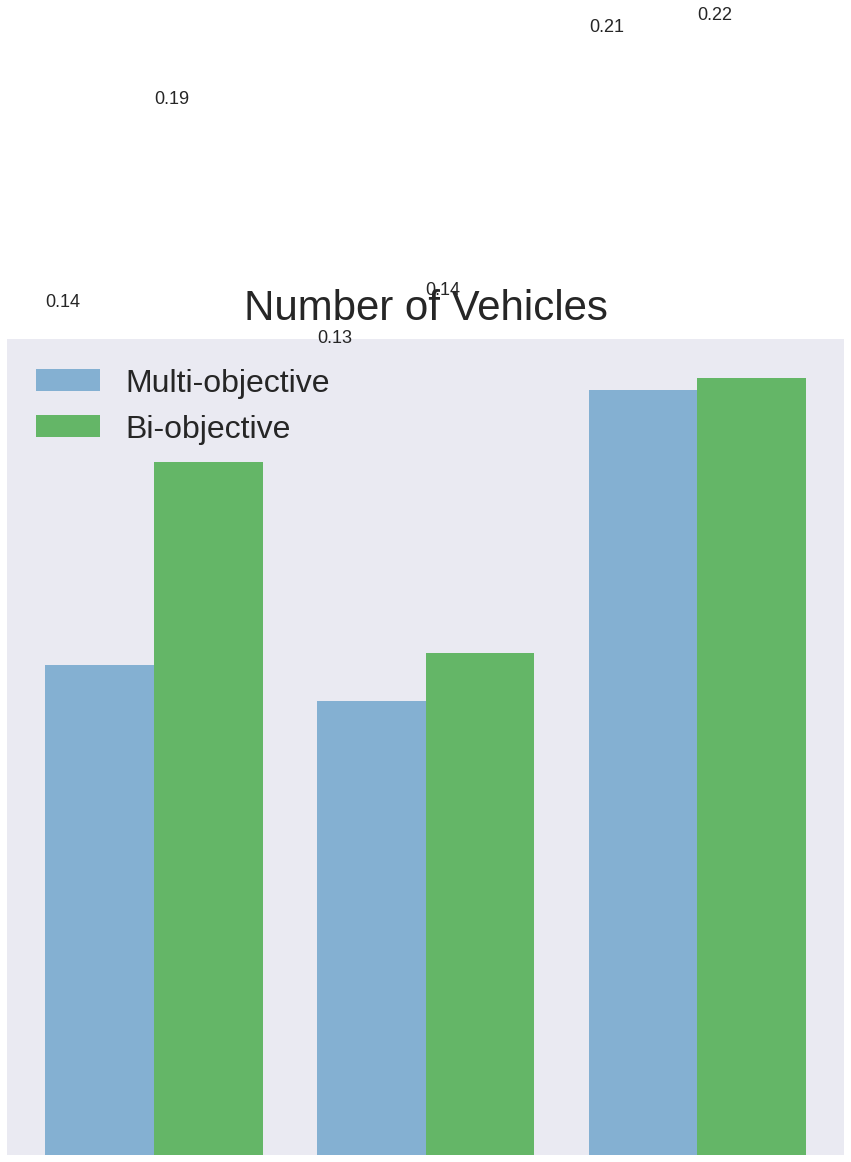

In [31]:
plt.bar(x = x1,height= multi_obj_vehicles,width=0.4,label="Multi-objective",alpha=0.5,color=sns.color_palette()[0])
for x in x1:
    offset = 0.08 if multi_obj_vehicles[x] - int(multi_obj_vehicles[x]) == 0 else 0.2
    
    
    plt.text(x-offset,multi_obj_vehicles[x]+0.1,round(multi_obj_vehicles[x],2),fontsize=18)


plt.bar(x= x2 ,height = bi_obj_vehicles,width=0.4,label="Bi-objective",alpha=0.7,color=sns.color_palette()[2])
for x in x2:
    offset = 0.08 if bi_obj_vehicles[int(x)] - int(bi_obj_vehicles[int(x)]) == 0 else 0.2
    plt.text(x-offset,bi_obj_vehicles[int(x)]+0.1,round(bi_obj_vehicles[int(x)],2),fontsize=18)
    
    

ax = plt.gca()
ax.set_yticks([])
ax.set_xticks([])
plt.legend(fontsize=32)
plt.title("Number of Vehicles",fontsize=42)
plt.savefig("fuel.png")

ValueError: shape mismatch: objects cannot be broadcast to a single shape

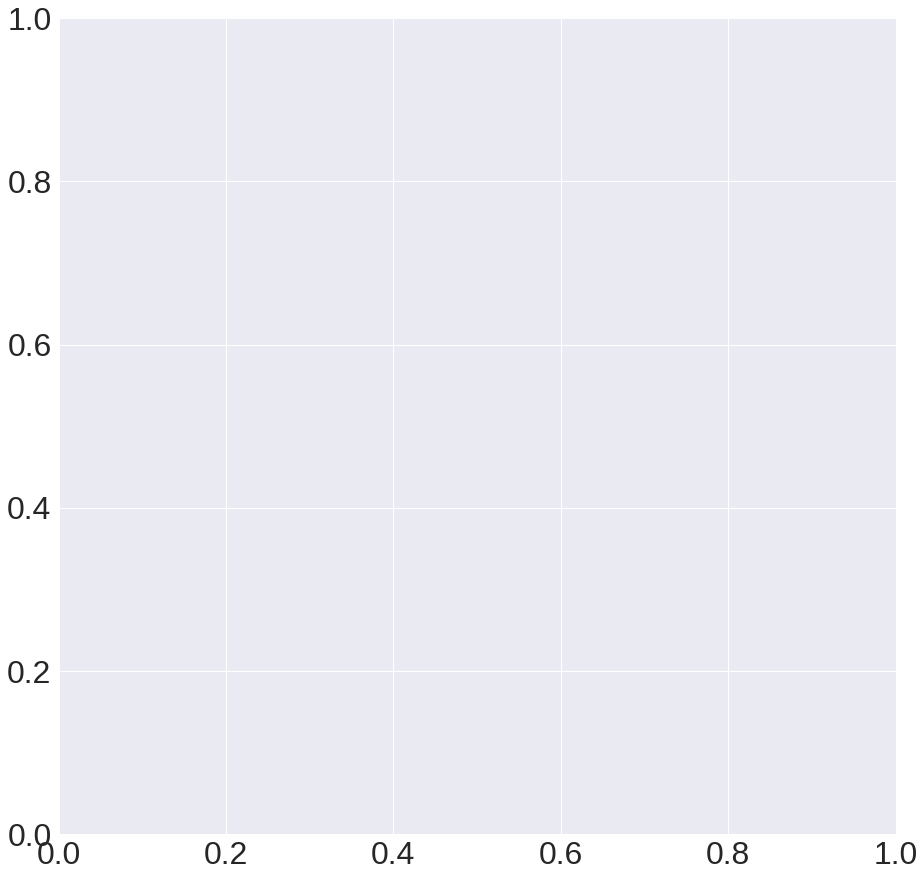

In [126]:
plt.bar(x = x1,height= multi_obj_vehicles,width=0.4,label="Multi-objective",alpha=0.5,color=sns.color_palette()[0])
dataset_size = [25,50,75]
for x in x1:
    offset = 0.08 if multi_obj_vehicles[x] - int(multi_obj_vehicles[x]) == 0 else 0.1
    plt.text(x-offset,multi_obj_vehicles[x]+0.1,round(multi_obj_vehicles[x],1),fontsize=24)
    plt.text(x,-.8,"{} Nodes".format(dataset_size[x]),fontsize=32)

plt.bar(x= x2 ,height = bi_obj_vehicles,width=0.4,label="Bi-objective",alpha=0.7,color=sns.color_palette()[2])
for x in x2:#range(len(x2)):
    offset = 0.08 if bi_obj_vehicles[int(x)] - int(bi_obj_vehicles[int(x)]) == 0 else 0.1
    plt.text(x-offset,bi_obj_vehicles[int(x)]+0.1,round(bi_obj_vehicles[int(x)],1),fontsize=24)
    
    

ax = plt.gca()
ax.set_yticks([])
ax.set_xticks([])
plt.legend(fontsize=32)
plt.title("Average Number of Vehicles",fontsize=42)
plt.savefig("vehicle_amount.png")

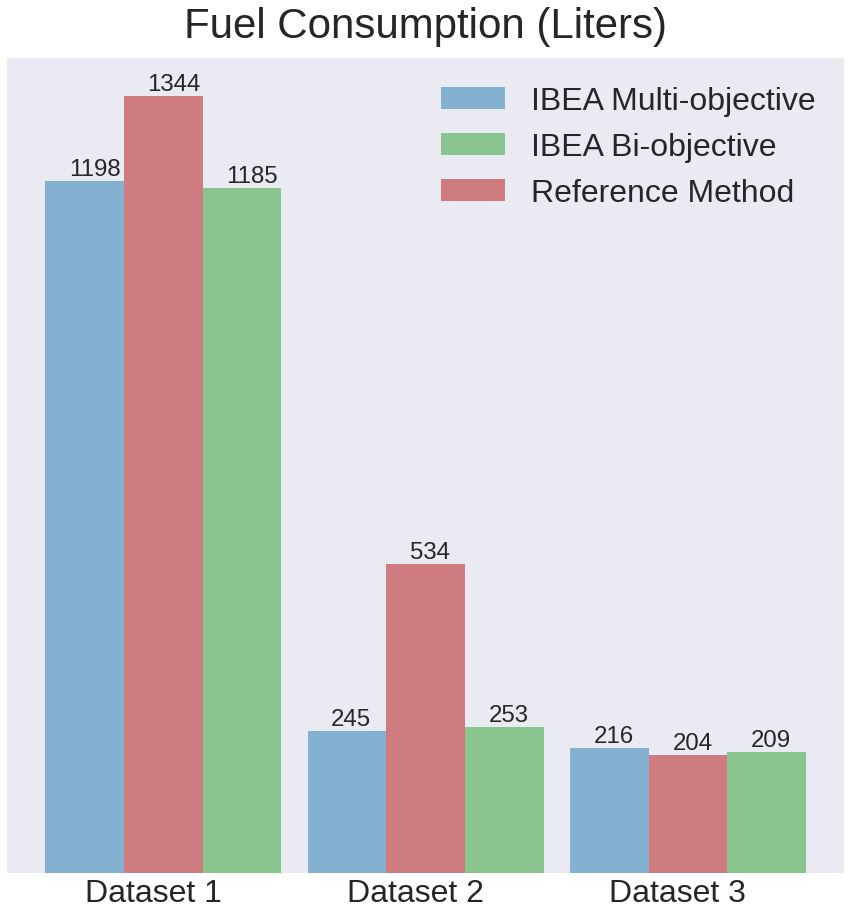

In [32]:
plt.bar(x = [1,2,3],height= our_fuel,width=0.3,label="IBEA Multi-objective",alpha=0.5,color=sns.color_palette()[0])
for x in range(1,4):
    plt.text(x-.06,our_fuel[x-1]+10,int(round(our_fuel[x-1],0)),fontsize=24)
    plt.text(x,-50,"Dataset {}".format(x),fontsize=32)
    
plt.bar(x = [1.6,2.6,3.6],height= our_fuel_2,width=0.3,label="IBEA Bi-objective",alpha=0.5,color=sns.color_palette()[2])
for x in [1.6,2.6,3.6]:
    plt.text(x-.06,our_fuel_2[int(x)-1]+10,int(round(our_fuel_2[int(x)-1],0)),fontsize=24)


plt.bar(x= [1.3,2.3,3.3],height = sigma_fuel,width=0.3,label="Reference Method",alpha=0.7,color=sns.color_palette()[12])
for x in [1.3,2.3,3.3]:
    plt.text(x-0.06,sigma_fuel[int(x)-1]+10,int(round(sigma_fuel[int(x)-1],0)),fontsize=24)
    
    

ax = plt.gca()
ax.set_yticks([])
ax.set_xticks([])
plt.legend(fontsize=32)
plt.title("Fuel Consumption (Liters)",fontsize=42)
plt.savefig("fuel.png")

In [46]:
((np.array(sigma_fuel) - np.array(our_fuel))/np.array(sigma_fuel)).mean()

0.1968705266941558

In [49]:
((np.array(sigma_time) - np.array(our_time))/np.array(sigma_time)).mean()

0.3203815667327426

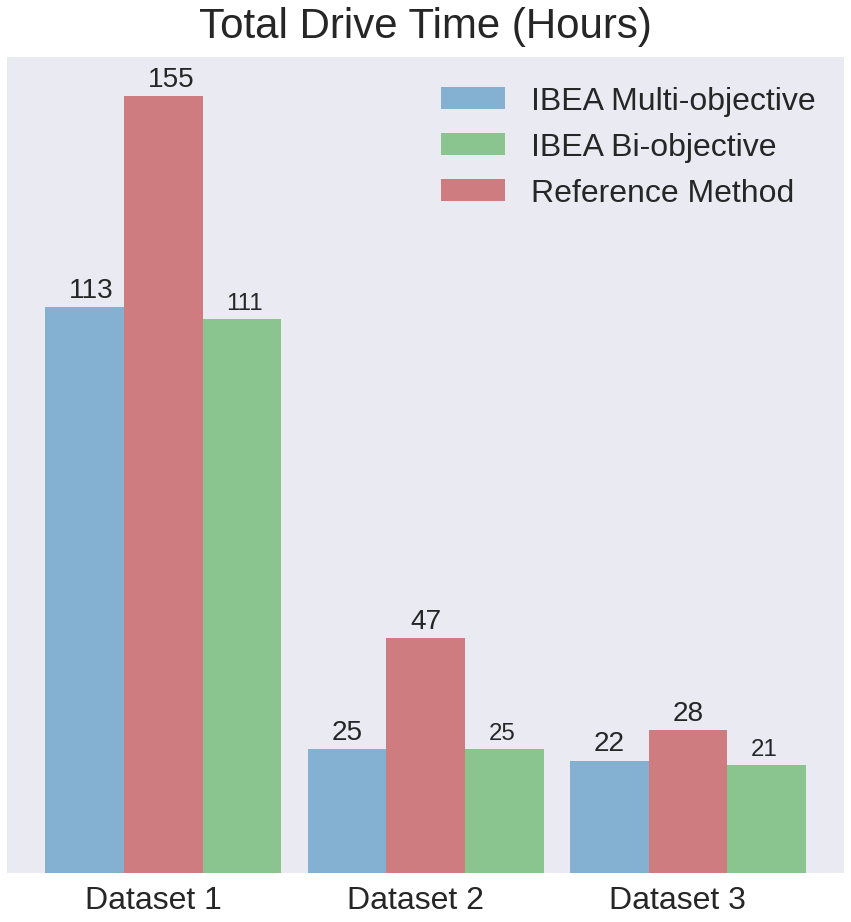

In [48]:
plt.bar(x = [1,2,3],height= our_time,width=0.3,label="IBEA Multi-objective",alpha=0.5,color=sns.color_palette()[0])
for x in range(1,4):
    plt.text(x-.06,our_time[x-1]+2,int(round(our_time[x-1],0)),fontsize=28)
    plt.text(x,-7,"Dataset {}".format(x),fontsize=32)
    
plt.bar(x = [1.6,2.6,3.6],height= our_time_2,width=0.3,label="IBEA Bi-objective",alpha=0.5,color=sns.color_palette()[2])
for x in [1.6,2.6,3.6]:
    plt.text(x-.06,our_time_2[int(x)-1]+2,int(round(our_time_2[int(x)-1],0)),fontsize=24)

plt.bar(x= [1.3,2.3,3.3],height = sigma_time,width=0.3,label="Reference Method",alpha=0.7,color=sns.color_palette()[12])
for x in [1.3,2.3,3.3]:
    plt.text(x-0.06,sigma_time[int(x)-1]+2,int(round(sigma_time[int(x)-1],0)),fontsize=28)

    
    
ax = plt.gca()
ax.set_yticks([])
ax.set_xticks([])
plt.legend(fontsize=32)
plt.title("Total Drive Time (Hours)",fontsize=42)
plt.savefig("time.png")


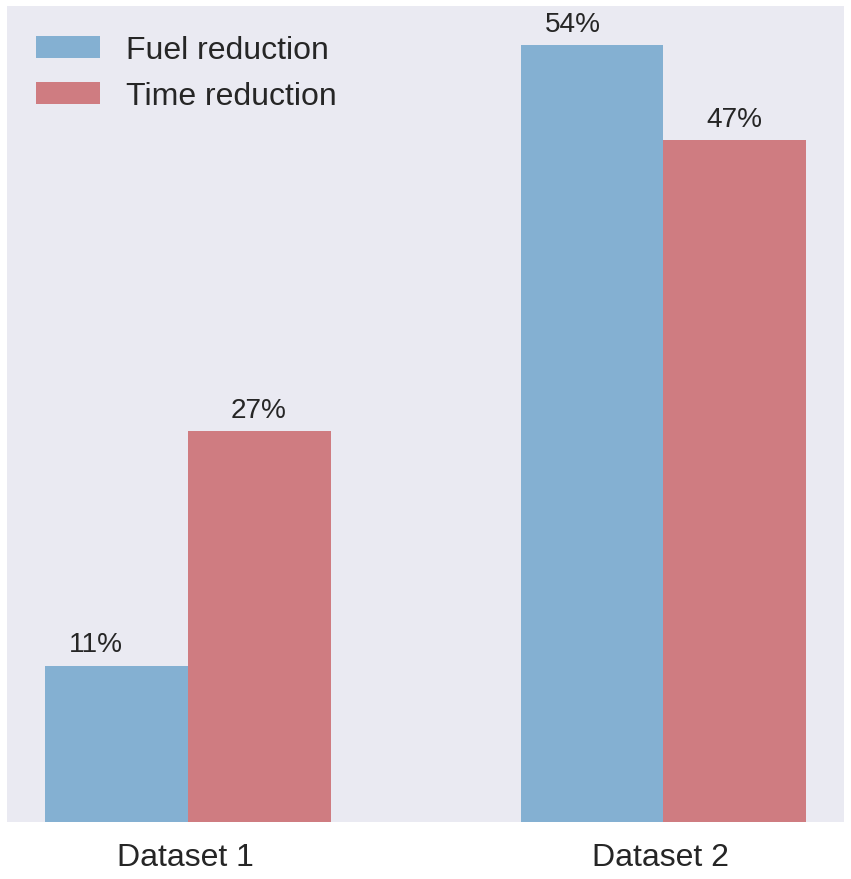

In [221]:
fuel_reduction = ((np.array(sigma_fuel) - np.array(our_fuel))/np.array(sigma_fuel))[:-1]
time_reduction = ((np.array(sigma_time) - np.array(our_time))/np.array(sigma_time))[:-1]

plt.bar(x = [1,2],height= fuel_reduction,width=0.3,label="Fuel reduction",alpha=0.5,color=sns.color_palette()[0])
for x in range(1,3):
    new_text = "{}%".format(int(round(fuel_reduction[x-1],2)*100))
    y_offset = 0.01 if fuel_reduction[x-1] > 0 else 0.07
    
    
    plt.text(x-.1,fuel_reduction[x-1]+y_offset,new_text,fontsize=28)
    plt.text(x,-0.03,"Dataset {}".format(x),fontsize=32)
    
plt.bar(x= [1.3,2.3],height = time_reduction,width=0.3,label="Time reduction",alpha=0.7,color=sns.color_palette()[12])
for x in [1.3,2.3]:
    new_text = "{}%".format(int(round(time_reduction[int(x)-1],2)*100))
    plt.text(x-0.06,time_reduction[int(x)-1]+.01,new_text,fontsize=28)

ax = plt.gca()
ax.set_yticks([])
ax.set_xticks([])
plt.legend(fontsize=32)
plt.show()

In [239]:
fuel_reduction.mean()

0.3247093708017774

In [240]:
time_reduction.mean()

0.37319115401781544

In [16]:
coords_11 = pd.read_csv("./sigma_data/data_frac_11.csv")[["Type","Lat","Long"]]
coords_2 = pd.read_csv("./sigma_data/data_frac_2.csv")[["Type","Lat","Long"]]
coords_3 = pd.read_csv("./sigma_data/data_frac_3.csv")[["Type","Lat","Long"]]

In [22]:
coordinates_all = pd.concat([coords_11,coords_2,coords_3])

In [23]:
coordinates_all.reset_index()

,index,Type,Lat,Long
0,0,1.0,58.587510,16.219090
1,1,1.0,58.470831,16.303156
2,2,1.0,58.048120,14.991280
3,3,1.0,56.406240,15.997170
4,4,1.0,56.662980,16.314560
...,...,...,...,...
133,21,3.0,59.847098,17.680204
134,22,2.0,57.731594,12.021305
135,23,3.0,57.694872,11.956346
136,24,3.0,57.303935,15.125353


In [32]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=(58.5476627, 13.9489607), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
icons = {0:"trash",1:"industry",2:"truck",3:'car'}
#numerical_route = sigma_routes[3][0]
for position in coordinates_all.iterrows():
    
    position_type = int(position[1]["Type"]) -1 
    coordinates = (position[1]["Lat"],position[1]["Long"])
    pos_icon = icons[position_type]
    Marker(coordinates,icon=folium.Icon(color=type_colors[position_type],icon_color='#FFFF00',icon=pos_icon,prefix="fa")).add_to(folium_map)
    
    
    
#     routes = []
    
#     for stop in route:
#         nodeType = 0
#         if route.index(stop) == len(route)-1:
#             nodeType =1
#         if route.index(stop) == 0:
#             nodeType =2
#         coordinates = (sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][0],sigma_coordinates[stop%len(sigma_routing_context.distance_matrix)][1])
#         routes.append(coordinates)
#         Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00')).add_to(folium_map)
  
    
#     #PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map
